In [3]:
#importing libraries
import re
# import shap
# import pickle
import joblib
import warnings
import numpy as np
import pandas as pd
# import xgboost as xgb
# import lightgbm as lgb
# import bamboolib as bam
import category_encoders as ce
import matplotlib.pyplot as plt
from joblib import parallel_backend
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier
np.set_printoptions(precision=3, suppress=True)
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [4]:
df = pd.read_excel(r"Clean_file_for_model.xlsx").drop(columns='Unnamed: 0')
df.columns

Index(['NICU_rating', 'Gender', 'Birth_Weight', 'O2_Therapy', 'Resp_Distress',
       'Septicemia', 'Blood_Transfusion', 'Treatment_Received', 'GA_Days',
       'PMA_Days', 'Age', 'Stage', 'Plus', 'Zone', 'NVI', 'ROP',
       'treatment_new', 'Delivery_Type'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NICU_rating         3282 non-null   float64
 1   Gender              9816 non-null   object 
 2   Birth_Weight        12204 non-null  float64
 3   O2_Therapy          12305 non-null  object 
 4   Resp_Distress       12305 non-null  object 
 5   Septicemia          12305 non-null  object 
 6   Blood_Transfusion   12305 non-null  object 
 7   Treatment_Received  12227 non-null  object 
 8   GA_Days             12287 non-null  float64
 9   PMA_Days            12273 non-null  float64
 10  Age                 12305 non-null  int64  
 11  Stage               1887 non-null   float64
 12  Plus                1327 non-null   object 
 13  Zone                6793 non-null   float64
 14  NVI                 12305 non-null  object 
 15  ROP                 12215 non-null  object 
 16  trea

In [26]:
df['Delivery_Type'].value_counts()

Full Term    3015
Pre Term       32
Name: Delivery_Type, dtype: int64

In [6]:
# New Feature
df['Preterm_severity'] = 0
df.loc[df['GA_Days'] <196, 'Preterm_severity'] = 3
df.loc[(df['GA_Days'] >=196) & (df['GA_Days'] <224) , 'Preterm_severity'] = 2
df.loc[(df['GA_Days'] >=224) & (df['GA_Days'] <= 259) , 'Preterm_severity'] = 1     

In [28]:
## serialising/saving dataframe

filename = 'final_dataframe_rop.joblib'
joblib.dump(df, open(filename, 'wb')) 


In [29]:
df.head()

,NICU_rating,Gender,Birth_Weight,O2_Therapy,Resp_Distress,Septicemia,Blood_Transfusion,Treatment_Received,GA_Days,PMA_Days,Age,Stage,Plus,Zone,NVI,ROP,treatment_new,Delivery_Type,Preterm_severity
0,NaN,M,1800.0,N,N,N,N,N,196.0,392.0,196,5.0,NaN,NaN,N,rop,N,NaN,2
1,NaN,F,1600.0,N,N,N,N,N,238.0,312.0,74,NaN,NaN,NaN,N,rop,N,NaN,1
2,NaN,M,1500.0,Y,N,Y,N,N,224.0,265.0,41,NaN,NaN,NaN,N,no rop,N,NaN,1
3,NaN,M,1500.0,N,N,N,N,N,231.0,287.0,56,NaN,NaN,NaN,N,no rop,N,NaN,1
4,NaN,F,1400.0,N,N,Y,N,N,231.0,231.0,0,NaN,NaN,NaN,N,rop,N,Full Term,1


In [8]:
df['ROP'].value_counts()

rop       8186
no rop    4029
Name: ROP, dtype: int64

In [9]:
df['NICU_rating'].value_counts()

1.0    1363
2.0    1334
3.0     497
4.0      88
Name: NICU_rating, dtype: int64

### 1. Treatment prediction model with nicu target encoded

In [10]:
# Step: Drop columns
# dropping 'Age' as it shows 74% colinearity with pma days & 'o2 therapy' because it does not playing any role
df_ROP = df.drop(columns=['Stage', 'Plus','Zone', 'NVI','Treatment_Received','treatment_new','PMA_Days'])

def label_encode(df_ROP):
    # Define the encoding map for 'Y', 'N', 'rop', and 'no rop'
    encoding_map = {'Y': 1, 'N': 0, 'rop': 1, 'no rop': 0, 'Full Term':0, 'Pre Term': 1,'M':1,'F':0}
    
    # Loop through all object (string) type columns
    for col in df_ROP.select_dtypes(include=['object']).columns:
        df_ROP[col] = df_ROP[col].map(encoding_map) 
    
    return df_ROP

# Apply the function to the DataFrame
df_ROP = label_encode(df_ROP)

In [11]:
# Change data type to Object
df_ROP['NICU_rating'] = df_ROP['NICU_rating'].astype('object')

In [12]:
df_ROP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NICU_rating        3282 non-null   object 
 1   Gender             9816 non-null   float64
 2   Birth_Weight       12204 non-null  float64
 3   O2_Therapy         12305 non-null  int64  
 4   Resp_Distress      12305 non-null  int64  
 5   Septicemia         12305 non-null  int64  
 6   Blood_Transfusion  12305 non-null  int64  
 7   GA_Days            12287 non-null  float64
 8   Age                12305 non-null  int64  
 9   ROP                12215 non-null  float64
 10  Delivery_Type      3047 non-null   float64
 11  Preterm_severity   12305 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 1.1+ MB


In [13]:
#creating dataframe with 0 missing values fro model training
df_ROP_notNull = df_ROP.dropna()

In [14]:
df_ROP_notNull.shape

(854, 12)

In [15]:
df_ROP_notNull['ROP'].value_counts()

1.0    505
0.0    349
Name: ROP, dtype: int64

### Removing outliers

In [16]:
def remove_outliers(df):
    # Select only numeric columns
    numeric_cols = ['Birth_Weight','GA_Days', 'Age']
    
    # Calculate the z-scores (standard deviation from the mean)
    z_scores = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()
    
    # Create a mask where values are within 3 standard deviations (-3 <= z <= 3)
    mask = (z_scores >= -3) & (z_scores <= 3)
    
    # Keep only rows where all values in numeric columns are within the threshold
    filtered_df = df[mask.all(axis=1)]
    
    # Count the number of rows deleted
    rows_deleted = len(df) - len(filtered_df)
    
    print(f"Number of records deleted: {rows_deleted}")
    
    return filtered_df

df_ROP_notNull = remove_outliers(df_ROP_notNull)

Number of records deleted: 34


In [17]:
df_ROP_notNull['ROP'].value_counts()

1.0    480
0.0    340
Name: ROP, dtype: int64

### Train test val split

In [18]:
X = df_ROP_notNull.drop(columns='ROP')
y = df_ROP_notNull['ROP']

#splitting for test set
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#splitting for validation set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr)


In [24]:
X_tr.head()

,NICU_rating,Gender,Birth_Weight,O2_Therapy,Resp_Distress,Septicemia,Blood_Transfusion,GA_Days,Age,Delivery_Type,Preterm_severity
10233,1.0,1.0,1700.0,0,0,0,0,245.0,23,0.0,1
9680,1.0,0.0,1500.0,1,0,0,0,224.0,54,0.0,1
9684,1.0,1.0,1790.0,1,0,0,0,224.0,51,0.0,1
8603,2.0,1.0,920.0,1,1,1,1,183.0,242,0.0,3
9205,2.0,1.0,1310.0,1,1,0,1,196.0,50,0.0,2


In [25]:
X_tr.columns

Index(['NICU_rating', 'Gender', 'Birth_Weight', 'O2_Therapy', 'Resp_Distress',
       'Septicemia', 'Blood_Transfusion', 'GA_Days', 'Age', 'Delivery_Type',
       'Preterm_severity'],
      dtype='object')

In [19]:
y_train.value_counts()

1.0    307
0.0    217
Name: ROP, dtype: int64

In [20]:
print("Training samples :", X_train.shape)
print("Test samples :", X_test.shape)
print("Validation samples :", X_val.shape)

Training samples : (524, 11)
Test samples : (164, 11)
Validation samples : (132, 11)


### Logistic Regression


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import pickle

# Define the columns for transformation
categorical_cols = ['NICU_rating'] # target encoding
numerical_cols = ['Birth_Weight', 'GA_Days', 'Age'] #standard scaler

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('woe', ce.WOEEncoder(), categorical_cols),
        ('scale', StandardScaler(), numerical_cols)
    ], remainder='passthrough'  # to keep the rest of the columns as-is
)


logit = LogisticRegression(class_weight='balanced',random_state=42)

# Create the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', logit)
])

# Assuming X_train and y_train are your features and target from training data
# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Save the fitted pipeline
joblib.dump(pipe, 'rop_pipe.joblib')


['rop_pipe.joblib']

In [22]:
# Make predictions on the val set
y_train_pred = pipe.predict(X_train)

# Evaluate the model
print('---------------------------------------------------------------')
print('\033[1m             Logistic regression : Train Accuracy\033[0m')
print('---------------------------------------------------------------')
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

y_val_pred = pipe.predict(X_val)
print('---------------------------------------------------------------')
print('\033[1m             Logistic regression : Validation Accuracy\033[0m')
print('---------------------------------------------------------------')

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

y_test_pred = pipe.predict(X_test)
print('---------------------------------------------------------------')
print('\033[1m             Logistic regression : Test Accuracy\033[0m')
print('---------------------------------------------------------------')

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

---------------------------------------------------------------
             Logistic regression : Train Accuracy
---------------------------------------------------------------
Accuracy: 0.8244274809160306
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       217
         1.0       0.88      0.81      0.84       307

    accuracy                           0.82       524
   macro avg       0.82      0.83      0.82       524
weighted avg       0.83      0.82      0.83       524

---------------------------------------------------------------
             Logistic regression : Validation Accuracy
---------------------------------------------------------------
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81        55
         1.0       0.88      0.83      0.85        77

    accuracy                           0.83       132
   macro avg       0.83      0.83   

ROC AUC: 0.8057598039215685


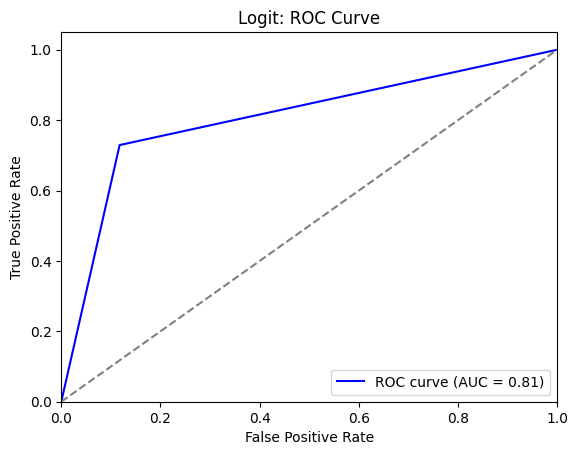

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Computing the AUC
auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC: {auc}')

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logit: ROC Curve')
plt.legend(loc="lower right")
plt.show()

ROC AUC: 0.87


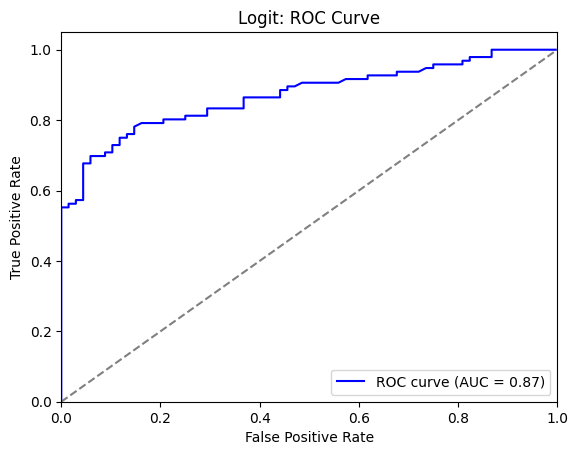

In [32]:
# Get the predicted probabilities for the positive class (class 1)
y_test_pred_proba = pipe.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

# Computing the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'ROC AUC: {auc:.2f}')

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logit: ROC Curve')
plt.legend(loc="lower right")
plt.show()

<Axes: ylabel='Feature'>

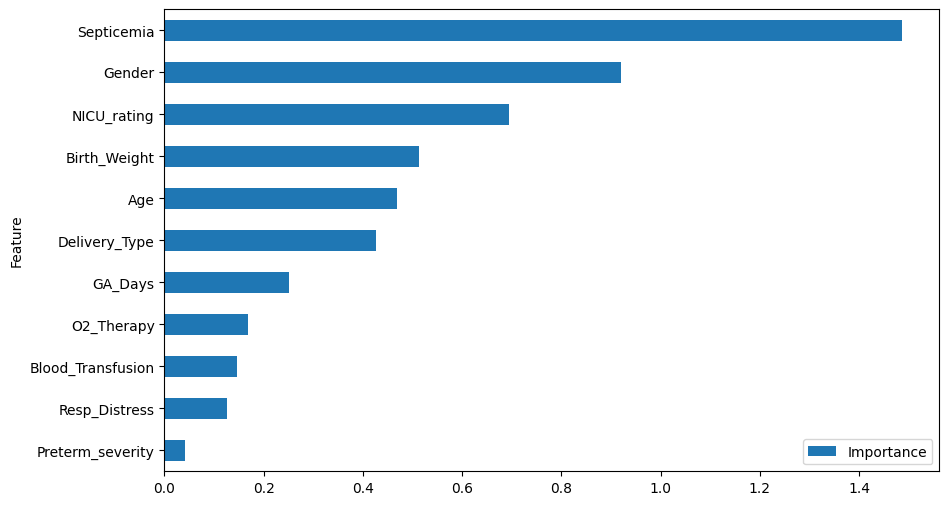

In [20]:
#feature impotance
coefficients = logit.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [34]:
# explainer = shap.KernelExplainer(logit.predict, X_train)
# shap_values = explainer.shap_values(X_train)

# # Summary plot (feature importance)
# shap.summary_plot(shap_values, X_train)


Using 524 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/524 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Create SHAP explainer for your model
explainer = shap.Explainer(logit, X_train)  
shap_values = explainer(X_train)

# SHAP bar plot (feature importance)
shap.plots.bar(shap_values)

In [35]:
# Making predictions (probabilities)
y_prob = pipe.predict_proba(X_test)

In [36]:
predicted_classes = np.argmax(y_prob, axis=1)

# Extracting the confidence score (max probability in each row)
confidence_scores = np.max(y_prob, axis=1)

In [37]:
# Printing the class along with the confidence score
for i, (pred_class, confidence) in enumerate(zip(predicted_classes, confidence_scores)):
    print(f"Sample {i+1}: Predicted Class = {pred_class}, Confidence Score = {confidence:.2f}")

Sample 1: Predicted Class = 0, Confidence Score = 0.60
Sample 2: Predicted Class = 0, Confidence Score = 0.87
Sample 3: Predicted Class = 0, Confidence Score = 0.85
Sample 4: Predicted Class = 1, Confidence Score = 0.55
Sample 5: Predicted Class = 0, Confidence Score = 0.70
Sample 6: Predicted Class = 0, Confidence Score = 0.93
Sample 7: Predicted Class = 1, Confidence Score = 0.85
Sample 8: Predicted Class = 0, Confidence Score = 0.92
Sample 9: Predicted Class = 0, Confidence Score = 0.96
Sample 10: Predicted Class = 0, Confidence Score = 0.71
Sample 11: Predicted Class = 0, Confidence Score = 0.95
Sample 12: Predicted Class = 0, Confidence Score = 0.84
Sample 13: Predicted Class = 1, Confidence Score = 0.96
Sample 14: Predicted Class = 1, Confidence Score = 0.88
Sample 15: Predicted Class = 0, Confidence Score = 0.71
Sample 16: Predicted Class = 1, Confidence Score = 0.98
Sample 17: Predicted Class = 1, Confidence Score = 0.86
Sample 18: Predicted Class = 1, Confidence Score = 0.78
S

In [ ]:
# # save the model 
# filename = 'Treatment_svm.sav'
# # Save the fitted model
# joblib.dump(logit, 'rop_pipe.joblib')
